In [1]:
import pandas as pd
import numpy as np
import psycopg2 as psql
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')
conn = psql.connect(dbname='datawarehouse',
                    host='localhost', user='gabriel', password='gyfu')


In [2]:
fireWeatherDataDB = pd.DataFrame(data={})
windowSize = 3
for city in range(1, 31):
    cur = conn.cursor()
    cur.execute('select d.day, d.month, d.year, count(f.*) from date d left join fires f on d.id = f.dateid and f.locationid = {} group by d.day, d.month, d.year order by d.year, d.month, d.day asc;'.format(city))
    fireCount = cur.fetchall()
    cur.close()
    cur = conn.cursor()
    cur.execute('select d.day, d.month, d.year, w.mimtemp, w.maxtemp, w.rainfall, w.windgustdir, w.windgustspeed from date d left join weather w on d.id = w.dateid and w.locationid = {} order by d.year, d.month, d.day asc;'.format(city))
    weatherData = cur.fetchall()
    cur.close()

    index = []
    count = []
    location = []
    for day in fireCount:
        index.append((day[0], day[1], day[2], city))
        count.append(day[3])
        location.append(city)

    fireCountDB = pd.DataFrame(
        data={'index': index, 'city': location, 'count': count})

    df = pd.DataFrame()
    for i in range(0, windowSize + 1):
        df['E{}'.format(i)] = fireCountDB['count'].shift(-i)
    df = df.iloc[:-windowSize]
    arr = df.values
    pDays = arr[:, :-1]

    pDays = np.insert(pDays, 0, np.zeros((3, 3)), axis=0)

    for i in range(0, windowSize):
        fireCountDB.insert(
            (2 + i), "countDay{}".format(-windowSize + i), pDays[:, i])

    for i in range(0, windowSize):
        fireCountDB = fireCountDB.drop(i)
    fireCountDB = fireCountDB.set_index('index')

    index = []
    mimtemp = []
    maxtemp = []
    rainfall = []
    windgustdir = []
    windgustspeed = []
    location = []
    for day in weatherData:
        index.append((day[0], day[1], day[2], city))
        mimtemp.append(day[3])
        maxtemp.append(day[4])
        rainfall.append(day[5])
        windgustdir.append(day[6])
        windgustspeed.append(day[7])

    weatherDataDB = pd.DataFrame(data={'index': index, 'mimtemp': mimtemp, 'maxtemp': maxtemp,
                                 'rainfall': rainfall, 'windgustdir': windgustdir, 'windgustspeed': windgustspeed})

    for i in range(0, windowSize):
        weatherDataDB = weatherDataDB.drop(i)
    weatherDataDB = weatherDataDB.set_index('index')
    sup = weatherDataDB.merge(fireCountDB, left_index=True, right_index=True)

    fireWeatherDataDB = fireWeatherDataDB.append(sup, ignore_index=False)
conn.close()


In [3]:
fireWeatherDataDB = fireWeatherDataDB[fireWeatherDataDB.mimtemp.notnull()]
fireWeatherDataDB = fireWeatherDataDB[fireWeatherDataDB.maxtemp.notnull()]
fireWeatherDataDB = fireWeatherDataDB[fireWeatherDataDB.rainfall.notnull()]
fireWeatherDataDB = fireWeatherDataDB[fireWeatherDataDB.windgustdir.notnull()]
fireWeatherDataDB = fireWeatherDataDB[fireWeatherDataDB.windgustspeed.notnull(
)]
fireWeatherDataDB


,mimtemp,maxtemp,rainfall,windgustdir,windgustspeed,city,countDay-3,countDay-2,countDay-1,count
index,,,,,,,,,,
"(7, 10, 2010, 1)",16.3,23.1,0.0,SSE,50.0,1,0.0,0.0,0.0,0
"(8, 10, 2010, 1)",13.8,19.5,0.0,ESE,35.0,1,0.0,0.0,0.0,0
"(9, 10, 2010, 1)",15.8,18.9,0.0,ESE,31.0,1,0.0,0.0,0.0,0
"(11, 10, 2010, 1)",16.5,21.1,1.2,ENE,56.0,1,0.0,0.0,0.0,0
"(12, 10, 2010, 1)",16.4,21.8,1.0,NNE,50.0,1,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
"(21, 6, 2017, 29)",8.9,13.1,0.8,SSE,26.0,29,0.0,0.0,3.0,1
"(22, 6, 2017, 29)",7.5,15.1,0.0,NW,26.0,29,0.0,3.0,1.0,0
"(23, 6, 2017, 29)",5.6,14.2,0.0,NNW,26.0,29,3.0,1.0,0.0,0


In [4]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
fireWeatherDataDB['windgustdir'] = enc.fit_transform(
    fireWeatherDataDB['windgustdir'])
fireWeatherDataDB


,mimtemp,maxtemp,rainfall,windgustdir,windgustspeed,city,countDay-3,countDay-2,countDay-1,count
index,,,,,,,,,,
"(7, 10, 2010, 1)",16.3,23.1,0.0,10,50.0,1,0.0,0.0,0.0,0
"(8, 10, 2010, 1)",13.8,19.5,0.0,2,35.0,1,0.0,0.0,0.0,0
"(9, 10, 2010, 1)",15.8,18.9,0.0,2,31.0,1,0.0,0.0,0.0,0
"(11, 10, 2010, 1)",16.5,21.1,1.2,1,56.0,1,0.0,0.0,0.0,0
"(12, 10, 2010, 1)",16.4,21.8,1.0,5,50.0,1,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
"(21, 6, 2017, 29)",8.9,13.1,0.8,10,26.0,29,0.0,0.0,3.0,1
"(22, 6, 2017, 29)",7.5,15.1,0.0,7,26.0,29,0.0,3.0,1.0,0
"(23, 6, 2017, 29)",5.6,14.2,0.0,6,26.0,29,3.0,1.0,0.0,0


In [5]:
from sklearn.preprocessing import StandardScaler
Scalers = {}
for colum in fireWeatherDataDB.columns.values:
    scaler = StandardScaler()
    scaler_data = fireWeatherDataDB[colum].values.copy()
    scaler_data.shape = (len(scaler_data), 1)
    fireWeatherDataDB[colum] = scaler.fit_transform(scaler_data)
    Scalers[colum] = scaler
fireWeatherDataDB


,mimtemp,maxtemp,rainfall,windgustdir,windgustspeed,city,countDay-3,countDay-2,countDay-1,count
index,,,,,,,,,,
"(7, 10, 2010, 1)",0.821600,0.162876,-0.293159,0.445724,0.726605,-1.717949,-0.261270,-0.262089,-0.264637,-0.262718
"(8, 10, 2010, 1)",0.405428,-0.363212,-0.293159,-1.300068,-0.315323,-1.717949,-0.261270,-0.262089,-0.264637,-0.262718
"(9, 10, 2010, 1)",0.738366,-0.450893,-0.293159,-1.300068,-0.593171,-1.717949,-0.261270,-0.262089,-0.264637,-0.262718
"(11, 10, 2010, 1)",0.854894,-0.129395,-0.145687,-1.518293,1.143377,-1.717949,-0.261270,-0.262089,-0.264637,-0.262718
"(12, 10, 2010, 1)",0.838247,-0.027100,-0.170265,-0.645396,0.726605,-1.717949,-0.261270,-0.262089,-0.264637,-0.140730
...,...,...,...,...,...,...,...,...,...,...
"(21, 6, 2017, 29)",-0.410269,-1.298478,-0.194844,0.445724,-0.940481,1.686677,-0.261270,-0.262089,0.106656,-0.140730
"(22, 6, 2017, 29)",-0.643326,-1.006207,-0.293159,-0.208948,-0.940481,1.686677,-0.261270,0.105478,-0.140873,-0.262718
"(23, 6, 2017, 29)",-0.959616,-1.137729,-0.293159,-0.427172,-0.940481,1.686677,0.105228,-0.139567,-0.264637,-0.262718


In [6]:
Scalers

{'mimtemp': StandardScaler(),
 'maxtemp': StandardScaler(),
 'rainfall': StandardScaler(),
 'windgustdir': StandardScaler(),
 'windgustspeed': StandardScaler(),
 'city': StandardScaler(),
 'countDay-3': StandardScaler(),
 'countDay-2': StandardScaler(),
 'countDay-1': StandardScaler(),
 'count': StandardScaler()}

In [7]:
target = fireWeatherDataDB.values[:, -1]
x = fireWeatherDataDB.values[:, :-1]
print(x)
print(target)


[[ 0.8216004   0.16287563 -0.29315885 ... -0.26126958 -0.26208888
  -0.26463701]
 [ 0.40542826 -0.36321156 -0.29315885 ... -0.26126958 -0.26208888
  -0.26463701]
 [ 0.73836597 -0.45089276 -0.29315885 ... -0.26126958 -0.26208888
  -0.26463701]
 ...
 [-0.95961634 -1.13772881 -0.29315885 ...  0.1052281  -0.13956655
  -0.26463701]
 [-0.85973503 -1.4884536   0.07552139 ... -0.13910368 -0.26208888
  -0.26463701]
 [-0.90967569 -1.25463708 -0.26858017 ... -0.26126958 -0.26208888
  -0.26463701]]
[-0.26271835 -0.26271835 -0.26271835 ... -0.26271835 -0.26271835
 -0.26271835]


In [8]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

mlpr = MLPRegressor(hidden_layer_sizes=(
    25, 11, 7, 5, 3,), activation='logistic', max_iter=1000)
fullPredictMLPR = cross_val_predict(mlpr, x, target, cv=10)

print('Mean Squared Error: %s' %
      (metrics.mean_squared_error(target, fullPredictMLPR)))
print('R2: %s' % (metrics.r2_score(target, fullPredictMLPR)))

fireWeatherDataDB['predictMLPR'] = fullPredictMLPR


Mean Squared Error: 0.7072839316318914
R2: 0.2927160683681087


In [9]:
from sklearn.linear_model import LinearRegression

lR = LinearRegression(copy_X=True, fit_intercept=False, normalize=True, positive=False)

fullPredictLR = cross_val_predict(lR, x, target, cv=10)
print('Mean Squared Error: %s' %
      (metrics.mean_squared_error(target, fullPredictLR)))
print('R2: %s' % (metrics.r2_score(target, fullPredictLR)))

fireWeatherDataDB['predictLR'] = fullPredictLR


Mean Squared Error: 0.6920413929656735
R2: 0.30795860703432665


In [10]:
for colum in fireWeatherDataDB.columns.values:
    scaler = 0
    if colum == 'predictMLPR' or colum == 'predictLR':
        scaler = Scalers['count']
    else:
        scaler = Scalers[colum]
    scaler_data = fireWeatherDataDB[colum].values.copy()
    scaler_data.shape = (len(scaler_data), 1)
    fireWeatherDataDB[colum] = scaler.inverse_transform(scaler_data)
fireWeatherDataDB


,mimtemp,maxtemp,rainfall,windgustdir,windgustspeed,city,countDay-3,countDay-2,countDay-1,count,predictMLPR,predictLR
index,,,,,,,,,,,,
"(7, 10, 2010, 1)",16.3,23.1,0.0,10.0,50.0,1.0,0.0,0.0,0.0,0.0,0.976780,0.360581
"(8, 10, 2010, 1)",13.8,19.5,0.0,2.0,35.0,1.0,0.0,0.0,0.0,0.0,1.337504,0.315139
"(9, 10, 2010, 1)",15.8,18.9,0.0,2.0,31.0,1.0,0.0,0.0,0.0,0.0,1.218263,-0.080504
"(11, 10, 2010, 1)",16.5,21.1,1.2,1.0,56.0,1.0,0.0,0.0,0.0,0.0,0.910644,0.143741
"(12, 10, 2010, 1)",16.4,21.8,1.0,5.0,50.0,1.0,0.0,0.0,0.0,1.0,0.949908,0.213015
...,...,...,...,...,...,...,...,...,...,...,...,...
"(21, 6, 2017, 29)",8.9,13.1,0.8,10.0,26.0,29.0,0.0,0.0,3.0,1.0,0.714279,0.882794
"(22, 6, 2017, 29)",7.5,15.1,0.0,7.0,26.0,29.0,0.0,3.0,1.0,0.0,1.108570,1.114184
"(23, 6, 2017, 29)",5.6,14.2,0.0,6.0,26.0,29.0,3.0,1.0,0.0,0.0,0.836962,0.544656


In [11]:
MoreeDB = fireWeatherDataDB.loc[fireWeatherDataDB['city'] == 19]
MoreeDB

,mimtemp,maxtemp,rainfall,windgustdir,windgustspeed,city,countDay-3,countDay-2,countDay-1,count,predictMLPR,predictLR
index,,,,,,,,,,,,
"(1, 1, 2009, 19)",16.4,38.7,0.0,7.0,54.0,19.0,0.0,1.0,4.0,0.0,4.949253,4.261237
"(2, 1, 2009, 19)",22.3,30.3,0.0,5.0,30.0,19.0,1.0,4.0,0.0,0.0,0.761013,1.185639
"(3, 1, 2009, 19)",21.2,33.3,0.0,1.0,46.0,19.0,4.0,0.0,0.0,1.0,0.631465,1.230014
"(4, 1, 2009, 19)",16.4,33.5,0.0,1.0,39.0,19.0,0.0,0.0,1.0,0.0,0.765995,2.321919
"(5, 1, 2009, 19)",19.2,34.5,0.0,9.0,35.0,19.0,0.0,1.0,0.0,2.0,0.508276,1.613110
...,...,...,...,...,...,...,...,...,...,...,...,...
"(21, 6, 2017, 19)",4.6,20.4,0.0,11.0,28.0,19.0,8.0,20.0,26.0,12.0,18.519665,15.797178
"(22, 6, 2017, 19)",6.5,21.5,0.0,0.0,31.0,19.0,20.0,26.0,12.0,20.0,17.041289,11.292405
"(23, 6, 2017, 19)",6.2,22.5,0.0,0.0,31.0,19.0,26.0,12.0,20.0,20.0,22.543368,12.716696


<AxesSubplot:xlabel='index'>

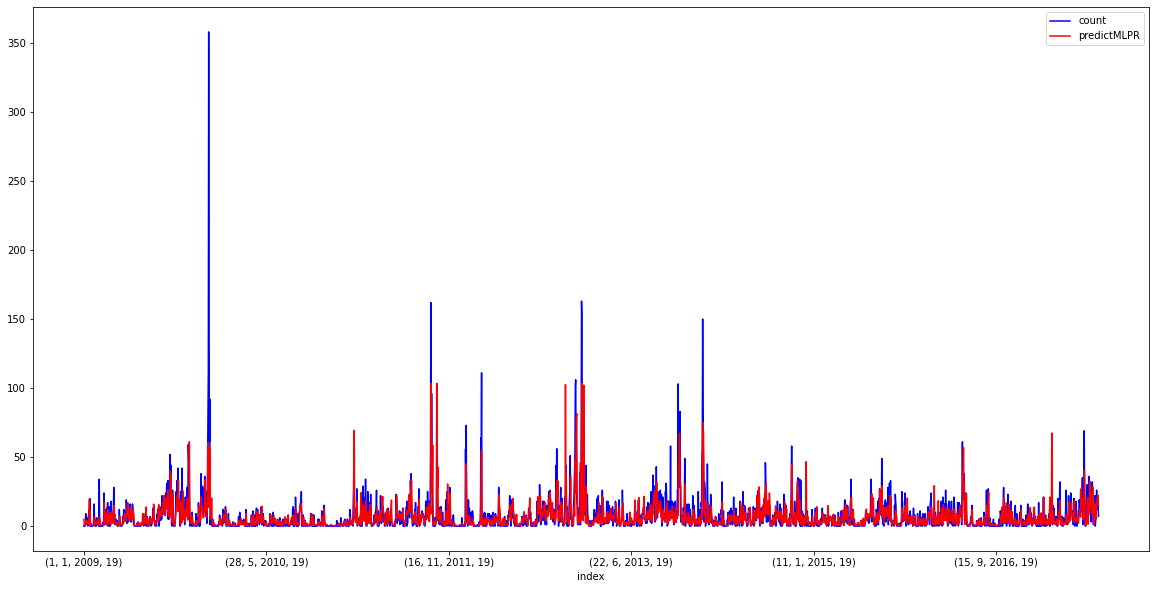

In [12]:
MoreeDB.plot(y=['count', 'predictMLPR'],
                       figsize=(20, 10), color=['blue', 'red'])


<AxesSubplot:xlabel='index'>

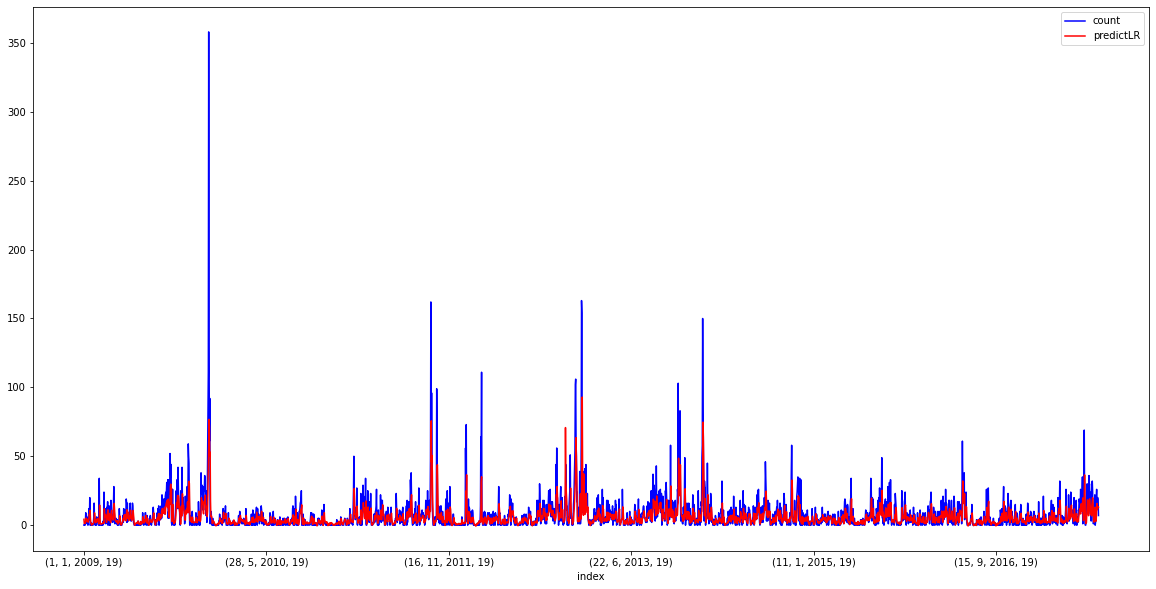

In [13]:
MoreeDB.plot(y=['count', 'predictLR'],
                       figsize=(20, 10), color=['blue', 'red'])


<AxesSubplot:xlabel='index'>

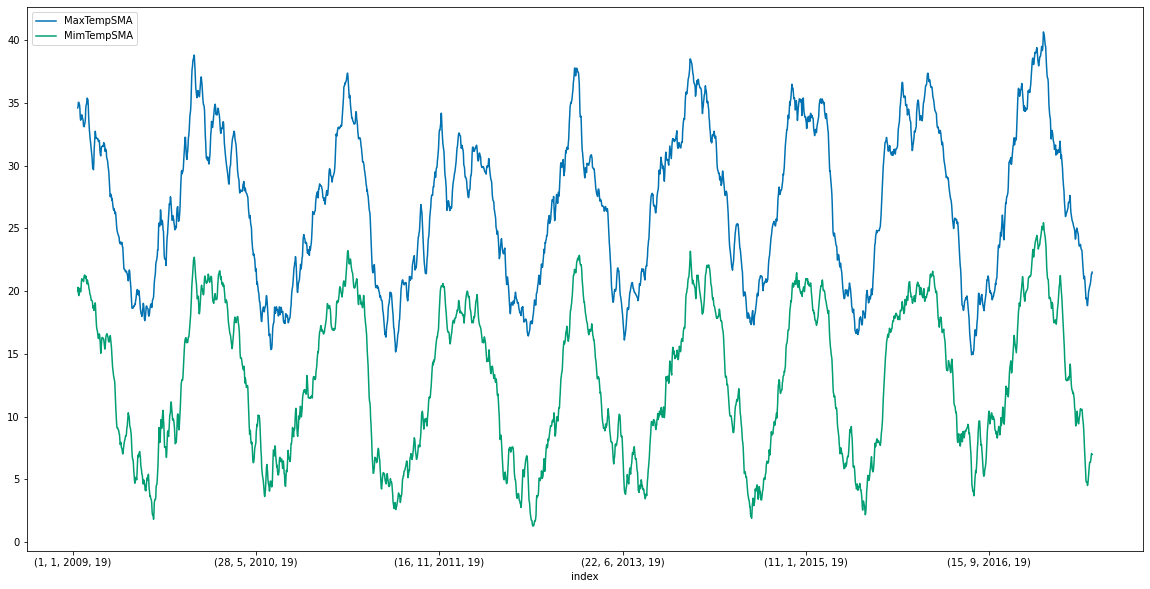

In [40]:
window = 15
mediaMovelDB = MoreeDB.copy()
mediaMovelDB = mediaMovelDB.reset_index()
for i in range(window - 1, mediaMovelDB.shape[0]):
    mediaMovelDB.loc[mediaMovelDB.index[i], 'MaxTempSMA'] = 0
    mediaMovelDB.loc[mediaMovelDB.index[i], 'MimTempSMA'] = 0
    mediaMovelDB.loc[mediaMovelDB.index[i], 'countSMA'] = 0
    for j in range(0, window):
        mediaMovelDB.iloc[i, mediaMovelDB.columns.get_loc(
            'MaxTempSMA')] += mediaMovelDB.iloc[i - j, mediaMovelDB.columns.get_loc('maxtemp')]
    for j in range(0, window):
        mediaMovelDB.iloc[i, mediaMovelDB.columns.get_loc(
            'MimTempSMA')] += mediaMovelDB.iloc[i - j, mediaMovelDB.columns.get_loc('mimtemp')]
    for j in range(0, window):
        mediaMovelDB.iloc[i, mediaMovelDB.columns.get_loc(
            'countSMA')] += mediaMovelDB.iloc[i - j, mediaMovelDB.columns.get_loc('count')]
            
mediaMovelDB['MaxTempSMA'] = mediaMovelDB['MaxTempSMA'] / window
mediaMovelDB['MimTempSMA'] = mediaMovelDB['MimTempSMA'] / window
mediaMovelDB['countSMA'] = mediaMovelDB['countSMA'] / window


mediaMovelDB.plot(x ='index', y=['MaxTempSMA', 'MimTempSMA'], figsize=(20, 10))


<AxesSubplot:xlabel='index'>

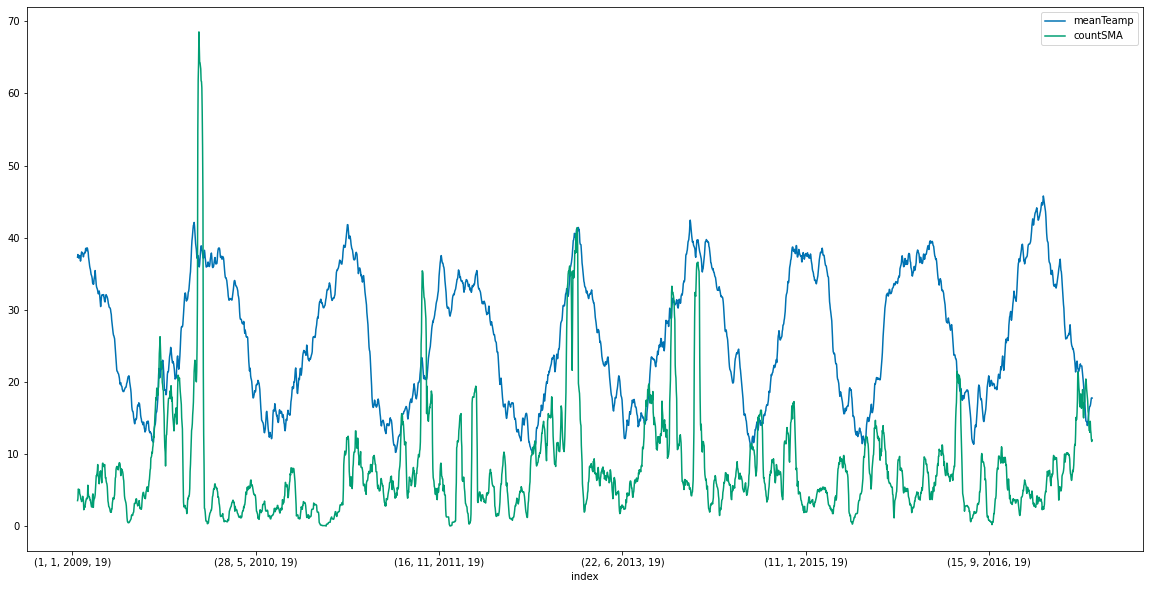

In [41]:
mediaMovelDB['meanTeamp'] = mediaMovelDB['MimTempSMA'] + mediaMovelDB['MaxTempSMA'] / 2

mediaMovelDB.plot(figsize=(
    20, 10), y=['meanTeamp', 'countSMA'], x='index')
